In [1]:
import nibabel as nib
from matplotlib import pyplot as plt
import os
import pickle
import numpy as np

#NN
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K

from tensorflow.python.client import device_lib

C:\Users\drago\anaconda3\envs\GWImages_2\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\drago\anaconda3\envs\GWImages_2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\drago\anaconda3\envs\GWImages_2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\drago\anaconda3\envs\GWImages_2\lib\site-packages

In [2]:
# Check GPU Detected
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3284409632655881556
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5090115584
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3655151014054167873
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


## Functions

In [3]:
def showImage(img, title):
    plt.imshow(img, cmap = "gray", origin = 'upper')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

In [4]:
def saveModel(directory_name, model, history):
    with open(directory_name + '_History.pkl', 'wb') as file_pi:
        pickle.dump(history, file_pi)

    model.save(directory_name + "_Model.h5")

In [5]:
#https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=By%20default,%20f1%20score%20is%20not%20part%20of,each%20epoch,%20need%20to%20make%20some%20more%20efforts.
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [6]:
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [7]:
#https://github.com/mkocabas/focal-loss-keras/blob/master/focal_loss.py
gamma = 2
alpha = .25
def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

## Grouping Files into Datasets

In [8]:
base_path="C:/Users/drago/Documents/gitrepos/individual-project-alzhiemers_detection/MRI Data/WM parc data - cropped images/Blur_Contour_Crop/"

In [9]:
# Break:
# 196 : 97 : 97
# 359 : 178 : 178

In [10]:
# File setup check
print("Total training AD: ", len(os.listdir(base_path+"1-Train/AD")))
print("Total validation AD: ", len(os.listdir(base_path+"2-Validation/AD")))
print("Total testing AD: ", len(os.listdir(base_path+"3-Test/AD")))

print("\nTotal training CN: ", len(os.listdir(base_path+"1-Train/CN")))
print("Total validation CN: ", len(os.listdir(base_path+"2-Validation/CN")))
print("Total testing CN: ", len(os.listdir(base_path+"3-Test/CN")))

Total training AD:  196
Total validation AD:  97
Total testing AD:  97

Total training CN:  359
Total validation CN:  178
Total testing CN:  178


In [11]:
# Build from directory dataset generators
train_aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_aug_datagen = ImageDataGenerator(rescale=1./255)

train_aug_generator = train_aug_datagen.flow_from_directory(
    base_path+"1-Train/",
    target_size=(256,256),
    batch_size=32,
    class_mode="binary")

validation_aug_generator = test_aug_datagen.flow_from_directory(
    base_path+"2-Validation/",
    target_size=(256,256),
    batch_size=32,
    class_mode="binary")

test_aug_generator = test_aug_datagen.flow_from_directory(
    base_path+"3-test/",
    target_size=(256,256),
    batch_size=32,
    class_mode="binary")

Found 555 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 275 images belonging to 2 classes.


### Data Preprosessing

In [12]:
# Check batches shape
for batch, label in train_aug_generator:
    print("data batch shape: ", batch.shape)
    print("label shape: ", label.shape)
    break

data batch shape:  (32, 256, 256, 3)
label shape:  (32,)


## Construct Model

In [13]:
# Construct model
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [15]:
augmentedVGG16 = models.Sequential()
augmentedVGG16.add(conv_base)
augmentedVGG16.add(layers.Flatten())
augmentedVGG16.add(layers.Dense(256, activation='relu'))
augmentedVGG16.add(Dropout(0.25))
augmentedVGG16.add(layers.Dense(1, activation='sigmoid'))
augmentedVGG16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 23,103,809
Trainable params: 23,103,809
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Freeze CNN
conv_base.trainable=False

In [17]:
# Model Compile
augmentedVGG16.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                         loss=focal_loss_fixed,
                         metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), get_f1, matthews_correlation])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Fitting and Saving Model

In [18]:
base_directory = "Models/VGG16_Dropout_FocalLoss_Augmented/dropout-25/"

In [19]:
checkpoint = ModelCheckpoint(filepath=base_directory+"checkpoints/best_model.hdf5", save_best_only=True)

# Fit model
VGG16_augmented_history = augmentedVGG16.fit_generator(
    train_aug_generator,
    steps_per_epoch=100,
    epochs=100,
    callbacks=[checkpoint],
    validation_data=validation_aug_generator,
    validation_steps=50)

VGG16_aug_history = VGG16_augmented_history.history

saveModel(base_directory + 'VGG16_drop_focal_aug', augmentedVGG16, VGG16_aug_history)

Epoch 1/100
100/100 [==============================] - 65s 654ms/step - loss: 0.0859 - acc: 0.4610 - precision: 0.6698 - recall: 0.3243 - get_f1: 0.3909 - matthews_correlation: 0.0373 - val_loss: 0.0830 - val_acc: 0.3557 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_get_f1: 0.0000e+00 - val_matthews_correlation: 0.0000e+00
Epoch 2/100
100/100 [==============================] - 56s 561ms/step - loss: 0.0724 - acc: 0.4879 - precision: 0.7307 - recall: 0.3305 - get_f1: 0.4126 - matthews_correlation: 0.1210 - val_loss: 0.0683 - val_acc: 0.3577 - val_precision: 1.0000 - val_recall: 0.0060 - val_get_f1: 0.0119 - val_matthews_correlation: 0.0160
Epoch 3/100
100/100 [==============================] - 54s 543ms/step - loss: 0.0695 - acc: 0.5078 - precision: 0.7859 - recall: 0.3342 - get_f1: 0.4287 - matthews_correlation: 0.2010 - val_loss: 0.0613 - val_acc: 0.5550 - val_precision: 0.9081 - val_recall: 0.3481 - val_get_f1: 0.4924 - val_matthews_correlation: 0.3120
Epoch 4/100
100/10

100/100 [==============================] - 57s 567ms/step - loss: 0.0543 - acc: 0.6851 - precision: 0.8828 - recall: 0.5896 - get_f1: 0.6973 - matthews_correlation: 0.4434 - val_loss: 0.0591 - val_acc: 0.7225 - val_precision: 0.7994 - val_recall: 0.7606 - val_get_f1: 0.7790 - val_matthews_correlation: 0.4156
Epoch 52/100
100/100 [==============================] - 55s 546ms/step - loss: 0.0540 - acc: 0.7015 - precision: 0.8902 - recall: 0.6148 - get_f1: 0.7141 - matthews_correlation: 0.4603 - val_loss: 0.0651 - val_acc: 0.7277 - val_precision: 0.7623 - val_recall: 0.8421 - val_get_f1: 0.7958 - val_matthews_correlation: 0.3798
Epoch 53/100
100/100 [==============================] - 55s 555ms/step - loss: 0.0542 - acc: 0.6953 - precision: 0.8785 - recall: 0.6174 - get_f1: 0.7179 - matthews_correlation: 0.4421 - val_loss: 0.0616 - val_acc: 0.7407 - val_precision: 0.8008 - val_recall: 0.8024 - val_get_f1: 0.7954 - val_matthews_correlation: 0.4185
Epoch 54/100
100/100 [======================

### Retrieving Saved Model and History

In [20]:
# Get history
with open(base_directory + 'VGG16_drop_focal_aug_history.pkl', 'rb') as file__pi:
    VGG16_aug_history = pickle.load(file__pi)
    
# Get best model
VGG16_aug_best = models.load_model(base_directory+"checkpoints/best_model.hdf5", custom_objects={"focal_loss_fixed": focal_loss_fixed, "get_f1": get_f1, "matthews_correlation": matthews_correlation})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Plotting Results

In [21]:
accuracy = VGG16_aug_history['acc']
validation_accuracy = VGG16_aug_history['val_acc']
precision = VGG16_aug_history['precision']
validation_precision = VGG16_aug_history['val_precision']
recall = VGG16_aug_history['recall']
validation_recall = VGG16_aug_history['val_recall']
f1 = VGG16_aug_history['get_f1']
validation_f1 = VGG16_aug_history['val_get_f1']
mcc = VGG16_aug_history['matthews_correlation']
validation_mcc = VGG16_aug_history['val_matthews_correlation']

loss = VGG16_aug_history['loss']
validation_loss = VGG16_aug_history['val_loss']

epochs = range(1, len(accuracy) + 1)


train_acc:  0.66174585
train_precision:  0.92895204
train_recall:  0.5178218
train_f1:  0.659595
train_mcc:  0.44308418
train_loss:  0.05189092170447111

valid_acc:  0.71009773
valid_precision:  0.8055866
valid_recall:  0.7268145
valid_f1:  0.75918937
valid_mcc:  0.38907337
valid_loss:  0.05680384129285812

best_acc:  0.70358306
best_precision:  0.90207714
best_recall:  0.6098295
best_f1:  0.7207361
best_mcc:  0.470447
best_loss:  0.054528213813900946


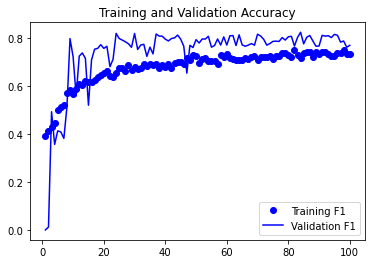

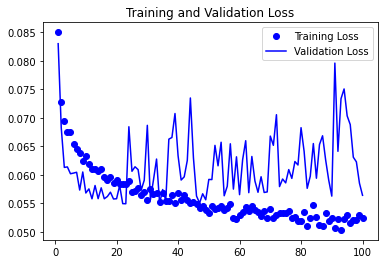

<Figure size 432x288 with 0 Axes>

In [22]:
# Accuracy Plots
plt.plot(epochs, f1, 'bo', label='Training F1')
plt.plot(epochs, validation_f1, 'b', label='Validation F1')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

# Generate acc loss percentages
train_loss, train_acc, train_precision, train_recall, train_f1, train_mcc = augmentedVGG16.evaluate_generator(train_aug_generator, steps=50)
print("\ntrain_acc: ", train_acc)
print("train_precision: ", train_precision)
print("train_recall: ", train_recall)
print("train_f1: ", train_f1)
print("train_mcc: ", train_mcc)
print("train_loss: ", train_loss)

# Generate acc loss percentages
valid_loss, valid_acc, valid_precision, valid_recall, valid_f1, valid_mcc = augmentedVGG16.evaluate_generator(validation_aug_generator, steps=50)
print("\nvalid_acc: ", valid_acc)
print("valid_precision: ", valid_precision)
print("valid_recall: ", valid_recall)
print("valid_f1: ", valid_f1)
print("valid_mcc: ", valid_mcc)
print("valid_loss: ", valid_loss)

# Output best epoch acc loss percentages
best_loss, best_acc, best_precision, best_recall, best_f1, best_mcc = VGG16_aug_best.evaluate_generator(validation_aug_generator, steps=50)
print("\nbest_acc: ", best_acc)
print("best_precision: ", best_precision)
print("best_recall: ", best_recall)
print("best_f1: ", best_f1)
print("best_mcc: ", best_mcc)
print("best_loss: ", best_loss)

## Fine Tune

In [23]:
base_directory = "Models/VGG16_Dropout_FocalLoss_Augmented_FineTune/dropout-25/"

In [24]:
checkpoint_directory = "checkpoints/"

### Set trainable higher layers

In [25]:
VGG16_aug_best.get_layer(name="vgg16").summary()
vgg16_base = VGG16_aug_best.get_layer(name="vgg16")
vgg16_base.trainable = True

set_trainable = False
for layer in vgg16_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
VGG16_aug_best.get_layer(name="vgg16").summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

### Compile and fit

In [26]:
# Model Compile
VGG16_aug_best.compile(optimizer=optimizers.RMSprop(lr=1e-5),
                         loss=focal_loss_fixed,
                         metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), get_f1, matthews_correlation])

In [27]:
checkpoint = ModelCheckpoint(filepath=base_directory+checkpoint_directory+"best_model.hdf5", save_best_only=True)

# Fit model
VGG16_history = VGG16_aug_best.fit_generator(
    train_aug_generator,
    steps_per_epoch=18,
    epochs=100,
    callbacks=[checkpoint],
    validation_data=validation_aug_generator,
    validation_steps=30)

VGG16_augmented_fine_tune_history = VGG16_history.history

saveModel(base_directory + 'VGG16_drop_focal_aug_fine_tune', VGG16_aug_best, VGG16_augmented_fine_tune_history)

Epoch 1/100
18/18 [==============================] - 16s 906ms/step - loss: 0.0672 - acc: 0.6216 - precision_1: 0.8311 - recall_1: 0.5209 - get_f1: 0.5879 - matthews_correlation: 0.3026 - val_loss: 0.0552 - val_acc: 0.6460 - val_precision_1: 0.9169 - val_recall_1: 0.4992 - val_get_f1: 0.6267 - val_matthews_correlation: 0.4114
Epoch 2/100
18/18 [==============================] - 13s 725ms/step - loss: 0.0580 - acc: 0.6523 - precision_1: 0.8673 - recall_1: 0.5460 - get_f1: 0.6557 - matthews_correlation: 0.3854 - val_loss: 0.0580 - val_acc: 0.7503 - val_precision_1: 0.8023 - val_recall_1: 0.8157 - val_get_f1: 0.8044 - val_matthews_correlation: 0.4458
Epoch 3/100
18/18 [==============================] - 13s 745ms/step - loss: 0.0626 - acc: 0.6180 - precision_1: 0.8419 - recall_1: 0.5042 - get_f1: 0.5693 - matthews_correlation: 0.3230 - val_loss: 0.0545 - val_acc: 0.6732 - val_precision_1: 0.9405 - val_recall_1: 0.5293 - val_get_f1: 0.6778 - val_matthews_correlation: 0.4739
Epoch 4/100
18/1

Epoch 26/100
18/18 [==============================] - 15s 826ms/step - loss: 0.0528 - acc: 0.7189 - precision_1: 0.8830 - recall_1: 0.6518 - get_f1: 0.7051 - matthews_correlation: 0.4586 - val_loss: 0.0499 - val_acc: 0.7025 - val_precision_1: 0.8779 - val_recall_1: 0.6275 - val_get_f1: 0.7284 - val_matthews_correlation: 0.4469
Epoch 27/100
18/18 [==============================] - 15s 832ms/step - loss: 0.0516 - acc: 0.7279 - precision_1: 0.8939 - recall_1: 0.6574 - get_f1: 0.7532 - matthews_correlation: 0.5185 - val_loss: 0.0503 - val_acc: 0.6916 - val_precision_1: 0.9503 - val_recall_1: 0.5490 - val_get_f1: 0.6877 - val_matthews_correlation: 0.4903
Epoch 28/100
18/18 [==============================] - 15s 837ms/step - loss: 0.0459 - acc: 0.7514 - precision_1: 0.9234 - recall_1: 0.6713 - get_f1: 0.7361 - matthews_correlation: 0.5231 - val_loss: 0.0676 - val_acc: 0.7590 - val_precision_1: 0.7984 - val_recall_1: 0.8436 - val_get_f1: 0.8198 - val_matthews_correlation: 0.4552
Epoch 29/100


Epoch 51/100
18/18 [==============================] - 15s 835ms/step - loss: 0.0454 - acc: 0.7441 - precision_1: 0.9157 - recall_1: 0.6657 - get_f1: 0.7496 - matthews_correlation: 0.5374 - val_loss: 0.0658 - val_acc: 0.7763 - val_precision_1: 0.8059 - val_recall_1: 0.8673 - val_get_f1: 0.8321 - val_matthews_correlation: 0.4819
Epoch 52/100
18/18 [==============================] - 15s 836ms/step - loss: 0.0436 - acc: 0.7928 - precision_1: 0.9266 - recall_1: 0.7382 - get_f1: 0.8101 - matthews_correlation: 0.6084 - val_loss: 0.0756 - val_acc: 0.7709 - val_precision_1: 0.7825 - val_recall_1: 0.8963 - val_get_f1: 0.8295 - val_matthews_correlation: 0.4546
Epoch 53/100
18/18 [==============================] - 15s 837ms/step - loss: 0.0431 - acc: 0.7892 - precision_1: 0.9353 - recall_1: 0.7242 - get_f1: 0.8046 - matthews_correlation: 0.6107 - val_loss: 0.0687 - val_acc: 0.7785 - val_precision_1: 0.7985 - val_recall_1: 0.8790 - val_get_f1: 0.8357 - val_matthews_correlation: 0.5069
Epoch 54/100


Epoch 76/100
18/18 [==============================] - 15s 838ms/step - loss: 0.0408 - acc: 0.7784 - precision_1: 0.9184 - recall_1: 0.7214 - get_f1: 0.7842 - matthews_correlation: 0.5950 - val_loss: 0.0533 - val_acc: 0.7503 - val_precision_1: 0.8440 - val_recall_1: 0.7534 - val_get_f1: 0.7920 - val_matthews_correlation: 0.4893
Epoch 77/100
18/18 [==============================] - 15s 838ms/step - loss: 0.0376 - acc: 0.8054 - precision_1: 0.9466 - recall_1: 0.7409 - get_f1: 0.8194 - matthews_correlation: 0.6363 - val_loss: 0.1040 - val_acc: 0.7687 - val_precision_1: 0.7624 - val_recall_1: 0.9328 - val_get_f1: 0.8358 - val_matthews_correlation: 0.4592
Epoch 78/100
18/18 [==============================] - 15s 826ms/step - loss: 0.0415 - acc: 0.7802 - precision_1: 0.9278 - recall_1: 0.7159 - get_f1: 0.8018 - matthews_correlation: 0.6111 - val_loss: 0.1173 - val_acc: 0.7633 - val_precision_1: 0.7497 - val_recall_1: 0.9531 - val_get_f1: 0.8362 - val_matthews_correlation: 0.4619
Epoch 79/100


### Retrieving Saved Model and History

In [28]:
with open(base_directory + 'VGG16_drop_focal_aug_fine_tune_history.pkl', 'rb') as file__pi:
    VGG16_augmented_fine_tune_history = pickle.load(file__pi)
    
VGG16_augmented_fine_tune_best = models.load_model(base_directory+checkpoint_directory+"best_model.hdf5", 
                                                   custom_objects={"focal_loss_fixed": focal_loss_fixed, "get_f1": get_f1, "matthews_correlation": matthews_correlation})

### Plotting Results

In [29]:
accuracy = VGG16_augmented_fine_tune_history['acc']
validation_accuracy = VGG16_augmented_fine_tune_history['val_acc']
precision = VGG16_augmented_fine_tune_history['precision_1']
validation_precision = VGG16_augmented_fine_tune_history['val_precision_1']
recall = VGG16_augmented_fine_tune_history['recall_1']
validation_recall = VGG16_augmented_fine_tune_history['val_recall_1']
f1 = VGG16_augmented_fine_tune_history['get_f1']
validation_f1 = VGG16_augmented_fine_tune_history['val_get_f1']
mcc = VGG16_augmented_fine_tune_history['matthews_correlation']
validation_mcc = VGG16_augmented_fine_tune_history['val_matthews_correlation']

loss = VGG16_augmented_fine_tune_history['loss']
validation_loss = VGG16_augmented_fine_tune_history['val_loss']

epochs = range(1, len(accuracy) + 1)


train_acc:  0.78125
train_precision:  0.9782609
train_recall:  0.6569343
train_f1:  0.78127724
train_mcc:  0.6261166
train_loss:  0.03511943029505866

valid_acc:  0.78571427
valid_precision:  0.872
valid_recall:  0.77304965
valid_f1:  0.8127545
valid_mcc:  0.56404334
valid_loss:  0.05579881157193865

best_acc:  0.74553573
best_precision:  0.90384614
best_recall:  0.6666667
best_f1:  0.7636767
best_mcc:  0.5301027
best_loss:  0.04961906586374555


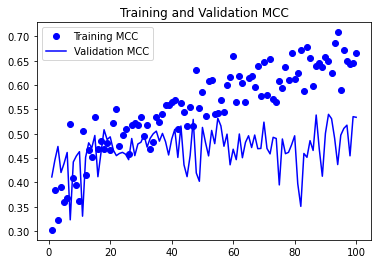

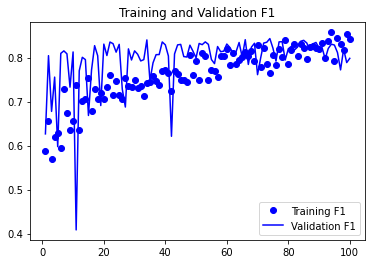

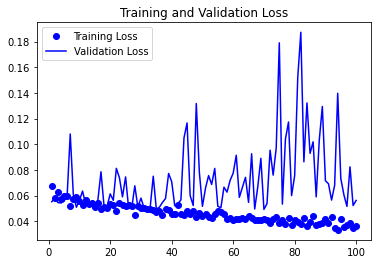

<Figure size 432x288 with 0 Axes>

In [30]:
# MCC Plots
plt.plot(epochs, mcc, 'bo', label='Training MCC')
plt.plot(epochs, validation_mcc, 'b', label='Validation MCC')
plt.title("Training and Validation MCC")
plt.legend()

plt.figure()

# F1 Plots
plt.plot(epochs, f1, 'bo', label='Training F1')
plt.plot(epochs, validation_f1, 'b', label='Validation F1')
plt.title("Training and Validation F1")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

# Generate acc loss percentages
train_loss, train_acc, train_precision, train_recall, train_f1, train_mcc = VGG16_aug_best.evaluate_generator(train_aug_generator, steps=7)
print("\ntrain_acc: ", train_acc)
print("train_precision: ", train_precision)
print("train_recall: ", train_recall)
print("train_f1: ", train_f1)
print("train_mcc: ", train_mcc)
print("train_loss: ", train_loss)

# Generate acc loss percentages
valid_loss, valid_acc, valid_precision, valid_recall, valid_f1, valid_mcc = VGG16_aug_best.evaluate_generator(validation_aug_generator, steps=7)
print("\nvalid_acc: ", valid_acc)
print("valid_precision: ", valid_precision)
print("valid_recall: ", valid_recall)
print("valid_f1: ", valid_f1)
print("valid_mcc: ", valid_mcc)
print("valid_loss: ", valid_loss)

# Output best epoch acc loss percentages
best_loss, best_acc, best_precision, best_recall, best_f1, best_mcc = VGG16_augmented_fine_tune_best.evaluate_generator(validation_aug_generator, steps=7)
print("\nbest_acc: ", best_acc)
print("best_precision: ", best_precision)
print("best_recall: ", best_recall)
print("best_f1: ", best_f1)
print("best_mcc: ", best_mcc)
print("best_loss: ", best_loss)